This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Getting started with neural networks: Classification and regression

## Classifying movie reviews: A binary classification example

### The IMDB dataset

**Loading the IMDB dataset**

In [1]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000) #영화 감상평 관련 글의 단어들이 "index" 데이터셋으로 존재 Ex. This movie is fantastic의 네 단어가 각각 "index" 데이터 1개씩으로 인식
    #사용 가능한 단어를 10000개까지로 한정

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
train_data[0]
#아래는 train_data 전체인데, list 하나에 문장 하나씩, 그리고 문장을 이루는 단어들이 index로 표현 되었음을 알 수 있음

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 8255, 78, 228,

In [4]:
train_labels[0]

np.int64(1)

In [5]:
max([max(sequence) for sequence in train_data]) #10000개 있음을 보임

9999

**Decoding reviews back to text**

In [7]:
word_index = imdb.get_word_index() #단어를 index로 변환
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()]) #word_index의 반대 : index를 단어로 변환
decoded_review = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]]) # 0번, 1번, 2번 index를 제외하고 단어 변환을 하기 위해 -3 (0번, 1번, 2번은 영화 리뷰 단어가 아닌 여백과 같은 속성임)

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Preparing the data

**Encoding the integer sequences via multi-hot encoding**

In [8]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension)) #25,000 (데이터 50,000개 중 train과 test 데이터가 각각 25,000개씩 있다고 수업에 설명함) * 10,000 (num_of_words로 위에서 설정함), 싹 다 0으로 시작
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1. #i번째 sequence에서 j번째 단어들이 사용됨 (예를 들어, This movie is good이 3, 5, 100, 2번째 인덱스 데이터라 하면 3, 5, 100, 2번째 원소들이 1로 치환), 25,000번 행까지 쭈욱 감
    return results
x_train = vectorize_sequences(train_data) #train_data에 대해 25,000 * 10,000짜리 만듦
x_test = vectorize_sequences(test_data) #test_data에 대해 25,000 * 10,000짜리 만듦

In [9]:
x_train[0] #사용된 단어 인덱스 부분이 1로 바뀜을 확인

array([0., 1., 1., ..., 0., 0., 0.])

In [10]:
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

### Building your model

**Model definition**

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(16, activation="relu"), #relu를 통해 치역을 0 이상으로 정의
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid") #마지막 Units가 1인 이유 : 좋냐 안 좋냐만 따지면 됨 /sigmoid : 치역을 실수 전체 집합에서 (0,1)로 정의 (0에 가까울수록 Negative, 1에 가까울수록 Positive)
])

**Compiling the model**

In [13]:
model.compile(optimizer="rmsprop", #optimizer 설정 (learning_rate를 따로 설정할 수도 있음)
              loss="binary_crossentropy", #loss_function
              metrics=["accuracy"]) #평가지표

### Validating your approach

**Setting aside a validation set**

In [14]:
x_val = x_train[:10000] #0번 인덱스에서 10000번 인덱스까지 지정
partial_x_train = x_train[10000:] #x_val 제외한 나머지 데이터를 통해 training 예정
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

**Training your model**

In [15]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val)) #fitting하는지 안 하는지 유효성 검증하고자 남겨둔 Sample

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.6820 - loss: 0.6236 - val_accuracy: 0.8584 - val_loss: 0.4389
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8847 - loss: 0.3869 - val_accuracy: 0.8801 - val_loss: 0.3353
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9149 - loss: 0.2731 - val_accuracy: 0.8880 - val_loss: 0.2923
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9337 - loss: 0.2132 - val_accuracy: 0.8891 - val_loss: 0.2781
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9433 - loss: 0.1805 - val_accuracy: 0.8874 - val_loss: 0.2772
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9561 - loss: 0.1472 - val_accuracy: 0.8860 - val_loss: 0.2821
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9671 - loss: 0.1234 - val_accuracy: 0.8852 - val_loss: 0.2970
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9690 - loss: 0.1101 - val_accuracy: 0.8757 - v

In [16]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

**Plotting the training and validation loss**

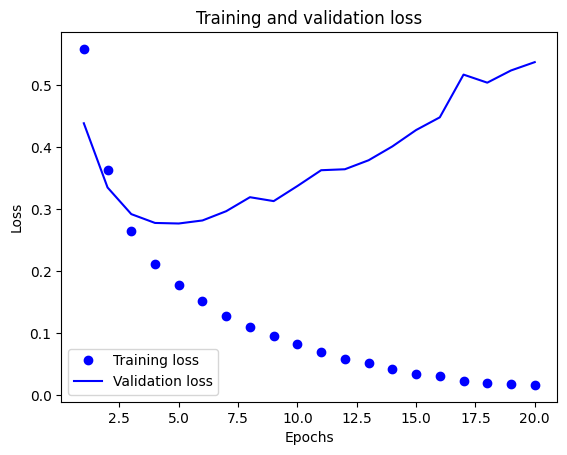

In [17]:
#loss를 보여주는 그래프
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
#그림을 보면 Training_loss는 줄어드는데, epoch=4 이후로 validation_loss가 늘어남 -> partial_x_train에는 잘 맞는데, 너무 partial_x_train에만 맞춰지는 바람에 x_val에는 fitting하지 않음 (overfitting)
#epoch를 너무 늘린 바람에 partial_x_train에게만 치중된 모델이 되어버린 것 -> epoch=4에서 validation_loss가 최소치이고 training_loss도 적정 수준이므로 epoch=4로 수정하여 실행

**Plotting the training and validation accuracy**

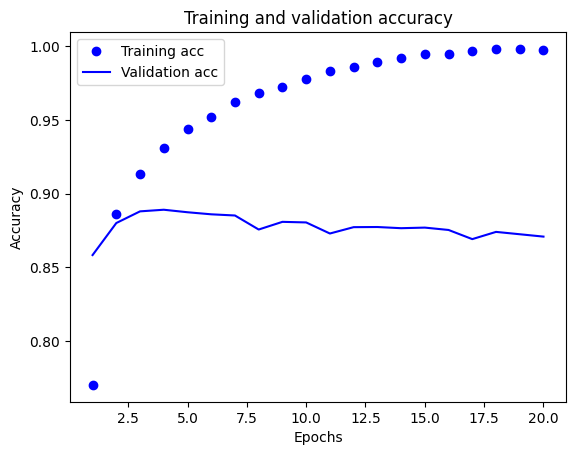

In [18]:
#accuracy를 보여주는 그래프
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Retraining a model from scratch**

In [19]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=4, batch_size=512)
#epoch=4에서 validation_loss가 최소치이고 training_loss도 적정 수준이므로 epoch=4로 수정하여 실행 (나머지는 안 건드림)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7313 - loss: 0.5529
Epoch 2/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9016 - loss: 0.2802
Epoch 3/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9254 - loss: 0.2131
Epoch 4/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9347 - loss: 0.1771
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8826 - loss: 0.2915


In [20]:
results # [0] 인덱스 = loss, [1] 인덱스 = accuracy

[0.28860580921173096, 0.8848000168800354]

### Using a trained model to generate predictions on new data

In [21]:
model.predict(x_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([[0.1947055 ],
       [0.99978226],
       [0.86384314],
       ...,
       [0.1106238 ],
       [0.07548165],
       [0.6666151 ]], dtype=float32)

### Further experiments

### Wrapping up

## Classifying newswires: A multiclass classification example

### The Reuters dataset

**Loading the Reuters dataset**

In [22]:
from tensorflow.keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000)
#영화 리뷰할 때랑 똑같음

2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
len(train_data)

8982

In [24]:
len(test_data)

2246

In [25]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

**Decoding newswires back to text**

In [26]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = " ".join([reverse_word_index.get(i - 3, "?") for i in
    train_data[0]])
#영화 리뷰할 때랑 똑같음

550378/550378 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [27]:
train_labels[10]

np.int64(3)

### Preparing the data

**Encoding the input data**

In [28]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

**Encoding the labels**

In [29]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1. #문장의 topic의 인덱스에 맞춰 원소 변환 -> topic이 sports이고 sports가 5번 데이터라 가정하면 5번 인덱스를 1로 바꿈
    return results
y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels) #위에 to_one_hot 역할을 to_categorical에 넣기만 하면 알아서 다 해줌

### Building your model

**Model definition**

In [ ]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
])

**Compiling the model**

In [ ]:
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

### Validating your approach

**Setting aside a validation set**

In [ ]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

**Training the model**

In [ ]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

**Plotting the training and validation loss**

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Plotting the training and validation accuracy**

In [ ]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Retraining a model from scratch**

In [ ]:
model = keras.Sequential([
  layers.Dense(64, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(x_train,
          y_train,
          epochs=9,
          batch_size=512)
results = model.evaluate(x_test, y_test)

In [ ]:
results

In [ ]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
hits_array.mean()

### Generating predictions on new data

In [ ]:
predictions = model.predict(x_test)

In [ ]:
predictions[0].shape

In [ ]:
np.sum(predictions[0])

In [ ]:
np.argmax(predictions[0])

### A different way to handle the labels and the loss

In [ ]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [ ]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

### The importance of having sufficiently large intermediate layers

**A model with an information bottleneck**

In [ ]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

### Further experiments

### Wrapping up

## Predicting house prices: A regression example

### The Boston Housing Price dataset

**Loading the Boston housing dataset**

In [ ]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [ ]:
train_data.shape

In [ ]:
test_data.shape

In [ ]:
train_targets

### Preparing the data

**Normalizing the data**

In [ ]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

### Building your model

**Model definition**

In [ ]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

### Validating your approach using K-fold validation

**K-fold validation**

In [ ]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

In [ ]:
all_scores

In [ ]:
np.mean(all_scores)

**Saving the validation logs at each fold**

In [ ]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

**Building the history of successive mean K-fold validation scores**

In [ ]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

**Plotting validation scores**

In [ ]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

**Plotting validation scores, excluding the first 10 data points**

In [ ]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

**Training the final model**

In [ ]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=130, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

In [ ]:
test_mae_score

### Generating predictions on new data

In [ ]:
predictions = model.predict(test_data)
predictions[0]

### Wrapping up

## Summary